# Coagulation with Various Kernel Strategies
In this tutorial, we demonstrate how to compute coagulation kernels using different kernel strategies, including the effects of electrical charge on aerosol particles.
We will:
- Define a particle size distribution.
- Assign charges to particles.
- Calculate necessary particle properties.
- Compute the coagulation kernel using different `KernelStrategy` classes.
- Plot and compare the results.

## Import Necessary Libraries
We import standard libraries and specific functions from the `particula` package that will be used in this tutorial.

In [1]:
# %%

import numpy as np
import matplotlib.pyplot as plt

# Particula imports
from particula.particles.properties.lognormal_size_distribution import (
    lognormal_pmf_distribution,
)
from particula.particles.properties import (
    coulomb_enhancement,
    diffusive_knudsen_number,
    friction_factor,
    cunningham_slip_correction,
    calculate_knudsen_number,
)
from particula.gas.properties import (
    get_dynamic_viscosity,
    molecule_mean_free_path,
)
from particula.util.reduced_quantity import reduced_self_broadcast

# Import kernel strategies
from particula.dynamics.coagulation import kernel

## Define the Particle Size Distribution
We create a size distribution for aerosol particles using a logarithmic scale for particle radius, ranging from 1 nm to 10 μm. We calculate the mass of particles in each size bin assuming they are spherical and have a standard density.

In [2]:
# %%

# Define the bins for particle radius using a logarithmic scale
radius_bins = np.logspace(start=-9, stop=-4, num=250)  # m (1 nm to 100 μm)

# Calculate the mass of particles for each size bin
mass_bins = 4 / 3 * np.pi * radius_bins**3 * 1e3  # kg

## Define Particle Charges
We assign charges to the particles. In this example, we assign negative charges to the smallest particles and positive charges to the larger particles. The charges are assigned based on the particle radius, with negative charges ranging
from -10 to -1 and positive charges ranging from +1 to +500 on a logarithmic scale.
We then plot the charge distribution against the particle radius.

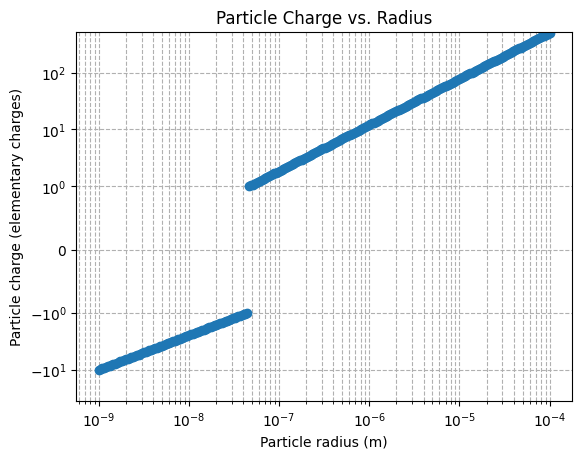

In [3]:
# %%

# Determine the number of radius bins
n_bins = len(radius_bins)

# Define the split index where charges transition from negative to positive
split_index = (
    n_bins // 3
)  # Assign the first third of particles negative charges

# Generate logarithmically spaced magnitudes for negative charges from 10 to 1
neg_magnitudes = np.logspace(np.log10(10), np.log10(1), num=split_index)
neg_charges = -neg_magnitudes  # Assign negative sign

# Generate logarithmically spaced magnitudes for positive charges from 1 to 500
pos_magnitudes = np.logspace(
    np.log10(1), np.log10(500), num=n_bins - split_index
)
pos_charges = pos_magnitudes  # Positive charges

# Combine the negative and positive charges into one array
charge_array = np.concatenate((neg_charges, pos_charges))

# Plot charge vs. radius
fig, ax = plt.subplots()
ax.plot(radius_bins, charge_array, marker="o", linestyle="none")
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=1)
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Particle charge (elementary charges)")
ax.set_title("Particle Charge vs. Radius")
ax.grid(True, which="both", ls="--")
plt.show()

## Calculate Coulomb Potential Ratio and Related Properties
In this section, we compute several properties necessary for calculating the coagulation kernel with charge effects:
- **Coulomb Potential Ratio**: Using `coulomb_enhancement.ratio`, we calculate the dimensionless Coulomb potential ratio, which quantifies the electrostatic interaction between charged particles.
- **Dynamic Viscosity**: Obtained from `get_dynamic_viscosity`, needed for calculating friction factors.
- **Mean Free Path**: Calculated using `molecule_mean_free_path`, important for determining the Knudsen number.
- **Knudsen Number**: Computed with `calculate_knudsen_number`, it characterizes the flow regime of the particles.
- **Slip Correction Factor**: Using `cunningham_slip_correction`, accounts for non-continuum effects at small particle sizes.
- **Friction Factor**: Calculated with `friction_factor`, needed for determining particle mobility.
- **Diffusive Knudsen Number**: Using `diffusive_knudsen_number`, combines the effects of particle diffusion and electrostatic interactions.

In [4]:
# %%

temperature = 298.15  # Temperature in Kelvin

# Calculate Coulomb potential ratio
coulomb_potential_ratio = coulomb_enhancement.ratio(
    radius_bins, charge_array, temperature=temperature
)

# Calculate gas properties
dynamic_viscosity = get_dynamic_viscosity(temperature=temperature)
mol_free_path = molecule_mean_free_path(
    temperature=temperature, dynamic_viscosity=dynamic_viscosity
)

# Calculate Knudsen number
knudsen_number = calculate_knudsen_number(
    mean_free_path=mol_free_path, particle_radius=radius_bins
)

# Calculate slip correction factor
slip_correction = cunningham_slip_correction(knudsen_number=knudsen_number)

# Calculate friction factor
friction_factor_value = friction_factor(
    radius=radius_bins,
    dynamic_viscosity=dynamic_viscosity,
    slip_correction=slip_correction,
)

# Calculate diffusive Knudsen number
diffusive_knudsen_values = diffusive_knudsen_number(
    radius=radius_bins,
    mass_particle=mass_bins,
    friction_factor=friction_factor_value,
    coulomb_potential_ratio=coulomb_potential_ratio,
    temperature=temperature,
)

# Prepare quantities for kernel calculations
sum_of_radii = radius_bins[:, np.newaxis] + radius_bins[np.newaxis, :]
reduced_mass = reduced_self_broadcast(mass_bins)
reduced_friction_factor = (
    friction_factor_value[:, np.newaxis]
    * friction_factor_value[np.newaxis, :]
    / (
        friction_factor_value[:, np.newaxis]
        + friction_factor_value[np.newaxis, :]
    )
)

## Hard Sphere Kernel Strategy
The **Hard Sphere** kernel strategy assumes that particles interact as hard spheres without any additional forces like electrostatic interactions. This is the simplest kernel and serves as a baseline for comparison.
**References:**
- This strategy is based on classical collision theory.

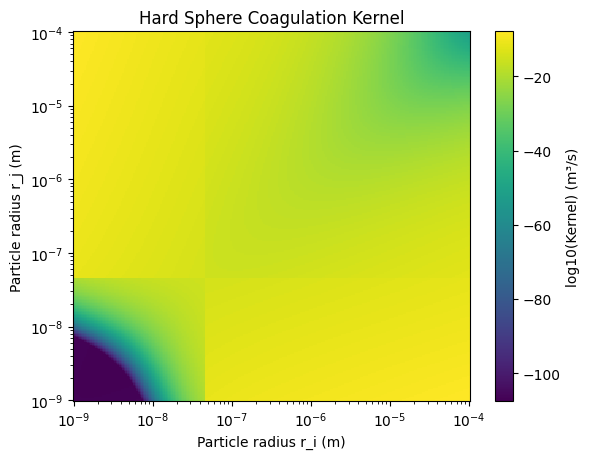

In [5]:
# %%

# Instantiate the Hard Sphere kernel strategy
kernel_strategy_hs = kernel.HardSphere()

# Compute the dimensionless kernel
dimensionless_kernel_hs = kernel_strategy_hs.dimensionless(
    diffusive_knudsen=diffusive_knudsen_values,
    coulomb_potential_ratio=None,  # Not used in this strategy
)

# Compute the dimensional kernel
dimensional_kernel_hs = kernel_strategy_hs.kernel(
    dimensionless_kernel=dimensionless_kernel_hs,
    coulomb_potential_ratio=coulomb_potential_ratio,
    sum_of_radii=sum_of_radii,
    reduced_mass=reduced_mass,
    reduced_friction_factor=reduced_friction_factor,
)

# Plot the Hard Sphere kernel
fig, ax = plt.subplots()
c = ax.pcolormesh(
    radius_bins, radius_bins, np.log10(dimensional_kernel_hs), shading="auto"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius r_i (m)")
ax.set_ylabel("Particle radius r_j (m)")
ax.set_title("Hard Sphere Coagulation Kernel")
fig.colorbar(c, ax=ax, label="log10(Kernel) (m³/s)")
plt.show()

## Coulomb Dyachkov 2007 Kernel Strategy
The **Coulomb Dyachkov 2007** kernel strategy accounts for the Coulomb potential between charged particles, as described by Dyachkov et al. (2007). It modifies the collision kernel to include electrostatic interactions.
**References:**
- Dyachkov, S. A., Kustova, E. V., & Kustov, A. V. (2007). Coagulation of particles in the transition regime: The effect of the Coulomb potential. *Journal of Chemical Physics*, 126(12). [Link](https://doi.org/10.1063/1.2713719)

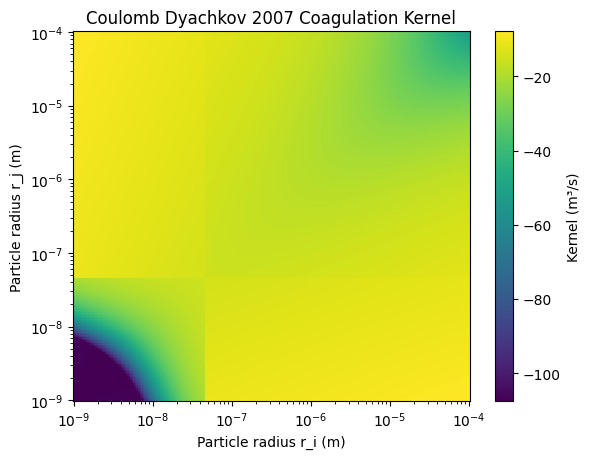

In [6]:
# %%

# Instantiate the Coulomb Dyachkov 2007 kernel strategy
kernel_strategy_dyachkov = kernel.CoulombDyachkov2007()

# Compute the dimensionless kernel
dimensionless_kernel_dyachkov = kernel_strategy_dyachkov.dimensionless(
    diffusive_knudsen=diffusive_knudsen_values,
    coulomb_potential_ratio=coulomb_potential_ratio,
)

# Compute the dimensional kernel
dimensional_kernel_dyachkov = kernel_strategy_dyachkov.kernel(
    dimensionless_kernel=dimensionless_kernel_dyachkov,
    coulomb_potential_ratio=coulomb_potential_ratio,
    sum_of_radii=sum_of_radii,
    reduced_mass=reduced_mass,
    reduced_friction_factor=reduced_friction_factor,
)

# Plot the Coulomb Dyachkov 2007 kernel
fig, ax = plt.subplots()
c = ax.pcolormesh(
    radius_bins, radius_bins, np.log10(dimensional_kernel_dyachkov), shading="auto"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius r_i (m)")
ax.set_ylabel("Particle radius r_j (m)")
ax.set_title("Coulomb Dyachkov 2007 Coagulation Kernel")
fig.colorbar(c, ax=ax, label="Kernel (m³/s)")
plt.show()

## Coulomb Gatti 2008 Kernel Strategy
The **Coulomb Gatti 2008** kernel strategy introduces an analytical model for particle charging in plasmas over a wide range of collisionality, as presented by Gatti and Kortshagen (2008).
**References:**
- Gatti, M., & Kortshagen, U. (2008). Analytical model of particle charging in plasmas over a wide range of collisionality. *Physical Review E*, 78(4). [Link](https://doi.org/10.1103/PhysRevE.78.046402)

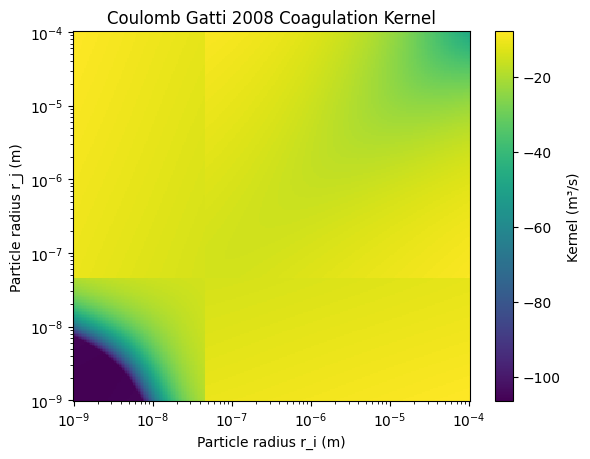

In [7]:
# %%

# Instantiate the Coulomb Gatti 2008 kernel strategy
kernel_strategy_gatti = kernel.CoulombGatti2008()

# Compute the dimensionless kernel
dimensionless_kernel_gatti = kernel_strategy_gatti.dimensionless(
    diffusive_knudsen=diffusive_knudsen_values,
    coulomb_potential_ratio=coulomb_potential_ratio,
)

# Compute the dimensional kernel
dimensional_kernel_gatti = kernel_strategy_gatti.kernel(
    dimensionless_kernel=dimensionless_kernel_gatti,
    coulomb_potential_ratio=coulomb_potential_ratio,
    sum_of_radii=sum_of_radii,
    reduced_mass=reduced_mass,
    reduced_friction_factor=reduced_friction_factor,
)

# Plot the Coulomb Gatti 2008 kernel
fig, ax = plt.subplots()
c = ax.pcolormesh(
    radius_bins, radius_bins, np.log10(dimensional_kernel_gatti), shading="auto"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius r_i (m)")
ax.set_ylabel("Particle radius r_j (m)")
ax.set_title("Coulomb Gatti 2008 Coagulation Kernel")
fig.colorbar(c, ax=ax, label="Kernel (m³/s)")
plt.show()

## Coulomb Gopalakrishnan 2012 Kernel Strategy
The **Coulomb Gopalakrishnan 2012** kernel strategy accounts for Coulomb-influenced collisions in aerosols and dusty plasmas, as described by Gopalakrishnan and Hogan (2012).
**References:**
- Gopalakrishnan, R., & Hogan, C. J. (2012). Coulomb-influenced collisions in aerosols and dusty plasmas. *Physical Review E*, 85(2). [Link](https://doi.org/10.1103/PhysRevE.85.026410)

C:\GitHub\particula\particula\dynamics\coagulation\transition_regime.py:215: RuntimeWarning: invalid value encountered in power
  continuum_limit / (1 + 1.598 * min_fxn**1.1709),


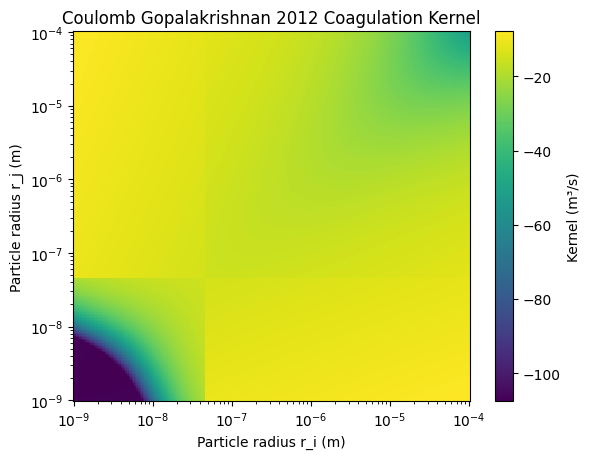

In [8]:
# %%

# Instantiate the Coulomb Gopalakrishnan 2012 kernel strategy
kernel_strategy_gopalakrishnan = kernel.CoulombGopalakrishnan2012()

# Compute the dimensionless kernel
dimensionless_kernel_gopalakrishnan = (
    kernel_strategy_gopalakrishnan.dimensionless(
        diffusive_knudsen=diffusive_knudsen_values,
        coulomb_potential_ratio=coulomb_potential_ratio,
    )
)

# Compute the dimensional kernel
dimensional_kernel_gopalakrishnan = kernel_strategy_gopalakrishnan.kernel(
    dimensionless_kernel=dimensionless_kernel_gopalakrishnan,
    coulomb_potential_ratio=coulomb_potential_ratio,
    sum_of_radii=sum_of_radii,
    reduced_mass=reduced_mass,
    reduced_friction_factor=reduced_friction_factor,
)

# Plot the Coulomb Gopalakrishnan 2012 kernel
fig, ax = plt.subplots()
c = ax.pcolormesh(
    radius_bins, radius_bins, np.log10(dimensional_kernel_gopalakrishnan), shading="auto"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius r_i (m)")
ax.set_ylabel("Particle radius r_j (m)")
ax.set_title("Coulomb Gopalakrishnan 2012 Coagulation Kernel")
fig.colorbar(c, ax=ax, label="Kernel (m³/s)")
plt.show()

## Coulomb Chahl 2019 Kernel Strategy
The **Coulomb Chahl 2019** kernel strategy provides an approximation for high potential, near free molecular regime Coulombic collisions in aerosols and dusty plasmas, as detailed by Chahl and Gopalakrishnan (2019).
**References:**
- Chahl, H. S., & Gopalakrishnan, R. (2019). High potential, near free molecular regime Coulombic collisions in aerosols and dusty plasmas. *Aerosol Science and Technology*, 53(8), 933-957.
[Link](https://doi.org/10.1080/02786826.2019.1614522)

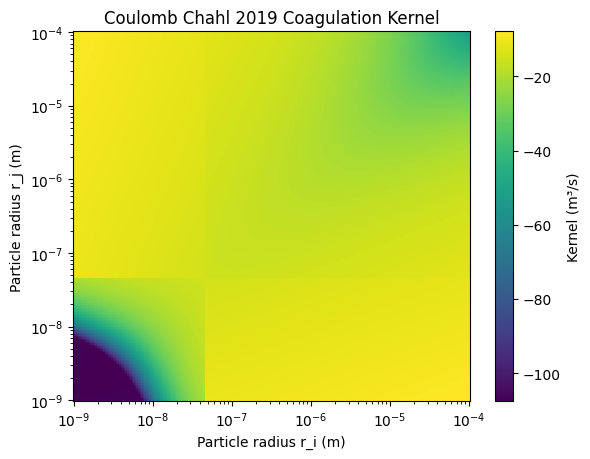

In [9]:
# %%

# Instantiate the Coulomb Chahl 2019 kernel strategy
kernel_strategy_chahl = kernel.CoulumbChahl2019()

# Compute the dimensionless kernel
dimensionless_kernel_chahl = kernel_strategy_chahl.dimensionless(
    diffusive_knudsen=diffusive_knudsen_values,
    coulomb_potential_ratio=coulomb_potential_ratio,
)

# Compute the dimensional kernel
dimensional_kernel_chahl = kernel_strategy_chahl.kernel(
    dimensionless_kernel=dimensionless_kernel_chahl,
    coulomb_potential_ratio=coulomb_potential_ratio,
    sum_of_radii=sum_of_radii,
    reduced_mass=reduced_mass,
    reduced_friction_factor=reduced_friction_factor,
)

# Plot the Coulomb Chahl 2019 kernel
fig, ax = plt.subplots()
c = ax.pcolormesh(
    radius_bins, radius_bins, np.log10(dimensional_kernel_chahl), shading="auto"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius r_i (m)")
ax.set_ylabel("Particle radius r_j (m)")
ax.set_title("Coulomb Chahl 2019 Coagulation Kernel")
fig.colorbar(c, ax=ax, label="Kernel (m³/s)")
plt.show()

## Compare Different Kernel Strategies
We compare the coagulation kernels obtained from different strategies to understand the influence of the chosen kernel on the coagulation process.

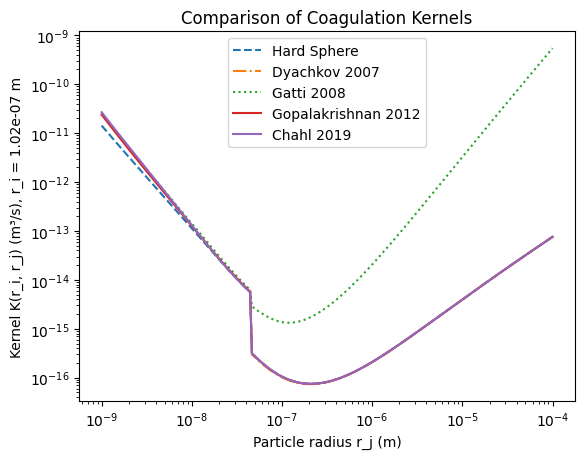

In [10]:
# %%

# Select a pair of particles for comparison (e.g., index 100)
index = 100

# Plot the kernel values for a selected particle size
fig, ax = plt.subplots()
ax.plot(
    radius_bins,
    dimensional_kernel_hs[index, :],
    label="Hard Sphere",
    linestyle="--",
)
ax.plot(
    radius_bins,
    dimensional_kernel_dyachkov[index, :],
    label="Dyachkov 2007",
    linestyle="-.",
)
ax.plot(
    radius_bins,
    dimensional_kernel_gatti[index, :],
    label="Gatti 2008",
    linestyle=":",
)
ax.plot(
    radius_bins,
    dimensional_kernel_gopalakrishnan[index, :],
    label="Gopalakrishnan 2012",
    linestyle="-",
)
ax.plot(
    radius_bins,
    dimensional_kernel_chahl[index, :],
    label="Chahl 2019",
    linestyle="-",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Particle radius r_j (m)")
ax.set_ylabel(f"Kernel K(r_i, r_j) (m³/s), r_i = {radius_bins[index]:.2e} m")
ax.set_title("Comparison of Coagulation Kernels")
ax.legend()
plt.show()

## Simulate Coagulation Over a Time Step Using Coulomb Chahl 2019 Kernel
We use the Coulomb Chahl 2019 kernel to simulate the coagulation process over a time step. This involves calculating the gain and loss rates of particle concentrations due to coagulation and the net rate of change.

In [11]:
# %%

# Import rate calculation functions
from particula.dynamics.coagulation import rate

# Make a number concentration distribution
number_concentration = lognormal_pmf_distribution(
    x_values=radius_bins,
    mode=np.array([10e-9, 200e-9, 1000e-9]),  # m
    geometric_standard_deviation=np.array([1.4, 1.5, 1.8]),
    number_of_particles=np.array([1e12, 1e12, 1e12]),  # per m^3
)

# Calculate gain and loss rates
gain_rate = rate.discrete_gain(
    radius=radius_bins,
    concentration=number_concentration,
    kernel=dimensional_kernel_chahl,
)
loss_rate = rate.discrete_loss(
    concentration=number_concentration,
    kernel=dimensional_kernel_chahl,
)

net_rate = gain_rate - loss_rate



## Plot Particle Concentration and Coagulation Rates
We visualize the initial particle concentration distribution and the coagulation rates to understand how charge effects influence the coagulation process over time.
- **Particle Concentration**: Shows the number concentration of particles across different sizes.
- **Coagulation Rates**: Displays the gain, loss, and net rates of coagulation, highlighting how particles of different sizes contribute to the overall process.

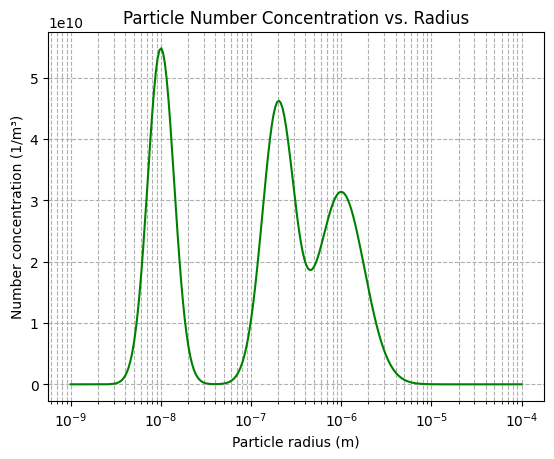

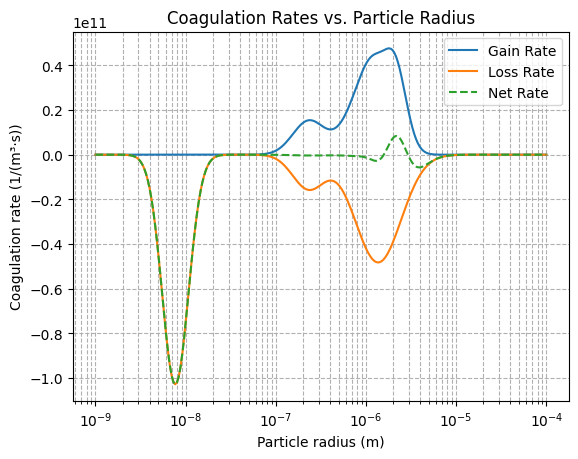

In [12]:
# %%

# Plot the number concentration
fig, ax1 = plt.subplots()
ax1.plot(radius_bins, number_concentration, color="green")
ax1.set_xscale("log")
ax1.set_xlabel("Particle radius (m)")
ax1.set_ylabel("Number concentration (1/m³)")
ax1.set_title("Particle Number Concentration vs. Radius")
ax1.grid(True, which="both", ls="--")
plt.show()

# Plot the coagulation rates
fig, ax2 = plt.subplots()
ax2.plot(radius_bins, gain_rate, label="Gain Rate")
ax2.plot(radius_bins, -loss_rate, label="Loss Rate")
ax2.plot(radius_bins, net_rate, label="Net Rate", linestyle="--")
ax2.set_xscale("log")
# ax2.set_yscale('log')
ax2.set_xlabel("Particle radius (m)")
ax2.set_ylabel("Coagulation rate (1/(m³·s))")
ax2.set_title("Coagulation Rates vs. Particle Radius")
ax2.legend()
ax2.grid(True, which="both", ls="--")
plt.show()